# **Introduction**

One of the important ways humans display emotions is through facial expressions. Facial expression recognition is one of the most powerful, natural and immediate means for human beings to communicate their emotions and intensions. Humans can be in some circumstances restricted from showing their emotions, such as hospitalized patients, or due to deficiencies; hence, better recognition of other human emotions will lead to effective communication. Automatic human emotion recognition has received much attention recently with the introduction of IOT and smart environments at hospitals, smart homes and smart cities. Intelligent personal assistants (IPAs), such as Siri, Alexia, Cortana and others, use natural language processing to communicate with humans, but when augmented with emotions, it increases the level of effective communication and human-level intelligence.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr1.jpg)

A convolutional neural network was used in our system to obtain improved facial emotion detection as it is applied to other computer fields such as face recognition and object detection. In addition, predictions are based on information given at a particular time.

Fig shows the network structure that is used for emotion detection using facial landmarks. This network takes an input image and attempts to predict the output emotion.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr6.jpg)

Load data from Kaggle to use in Colab

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [3]:
!kaggle datasets download "apollo2506/facial-recognition-dataset"

 59% 35.0M/59.7M [00:00<00:00, 57.7MB/s]
100% 59.7M/59.7M [00:00<00:00, 151MB/s] 


In [4]:
!unzip facial-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/Training/Sad/Sad-370.jpg  
  inflating: Training/Training/Sad/Sad-3700.jpg  
  inflating: Training/Training/Sad/Sad-3701.jpg  
  inflating: Training/Training/Sad/Sad-3702.jpg  
  inflating: Training/Training/Sad/Sad-3703.jpg  
  inflating: Training/Training/Sad/Sad-3704.jpg  
  inflating: Training/Training/Sad/Sad-3705.jpg  
  inflating: Training/Training/Sad/Sad-3706.jpg  
  inflating: Training/Training/Sad/Sad-3707.jpg  
  inflating: Training/Training/Sad/Sad-3708.jpg  
  inflating: Training/Training/Sad/Sad-3709.jpg  
  inflating: Training/Training/Sad/Sad-371.jpg  
  inflating: Training/Training/Sad/Sad-3710.jpg  
  inflating: Training/Training/Sad/Sad-3711.jpg  
  inflating: Training/Training/Sad/Sad-3712.jpg  
  inflating: Training/Training/Sad/Sad-3713.jpg  
  inflating: Training/Training/Sad/Sad-3714.jpg  
  inflating: Training/Training/Sad/Sad-3715.jpg  
  inflating: Training/Training/Sad/Sad-3716.jpg  
 

**Import libraries**

In [5]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# **Load Data and Plot Samples**

In [6]:
TRAIN_DIR = ('/content/Training/Training/')
TEST_DIR = ('/content/Testing/Testing/')

In [7]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [8]:
IMG_SIZE= (48, 48)

In [9]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


28273 images loaded from /content/Training/Training/ directory.


In [10]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [11]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00,  9.76it/s]


7067 images loaded from /content/Testing/Testing/ directory.


In [12]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

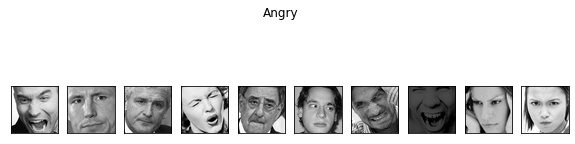

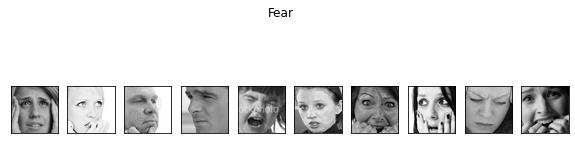

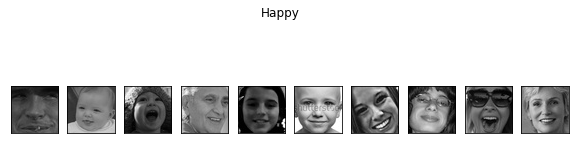

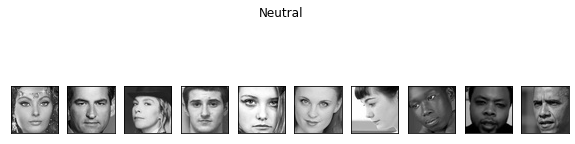

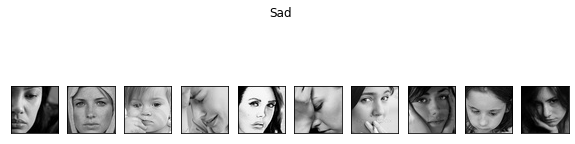

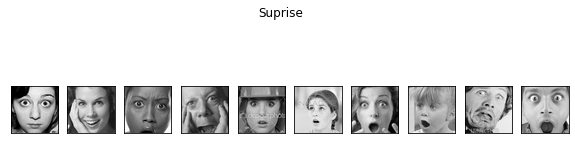

In [13]:
plot_samples(X_train, y_train, train_labels, 10)

**Encoding Classes**

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [14]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [15]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

# **Model Building**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

![](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

In [16]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [17]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [18]:
def deep_model(model, X_train, Y_train, epochs, batch_size):
   
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1)
    return history

In [19]:
epochs = 30
batch_size = 64

history = deep_model(model, X_train, Y_train, epochs, batch_size)


Epoch 1/30
442/442 [==============================] - 73s 62ms/step - loss: 0.4853 - accuracy: 0.2395
Epoch 2/30
442/442 [==============================] - 26s 60ms/step - loss: 0.4472 - accuracy: 0.2532
Epoch 3/30
442/442 [==============================] - 27s 61ms/step - loss: 0.4120 - accuracy: 0.3295
Epoch 4/30
442/442 [==============================] - 27s 61ms/step - loss: 0.3720 - accuracy: 0.4179
Epoch 5/30
442/442 [==============================] - 27s 62ms/step - loss: 0.3449 - accuracy: 0.4620
Epoch 6/30
442/442 [==============================] - 28s 63ms/step - loss: 0.3261 - accuracy: 0.5067
Epoch 7/30
442/442 [==============================] - 28s 63ms/step - loss: 0.3030 - accuracy: 0.5529
Epoch 8/30
442/442 [==============================] - 28s 64ms/step - loss: 0.2851 - accuracy: 0.5826
Epoch 9/30
442/442 [==============================] - 28s 63ms/step - loss: 0.2670 - accuracy: 0.6261
Epoch 10/30
442/442 [==============================] - 28s 64ms/step - loss: 0.247

**Confusion Matrix**

Additionally, the sensitivity, specificity, F-score, and accuracy are calculated for each class by using the following calculated confusion matrix Fig for the six classes for emotion detection. Each class is used against all classes in order to find those performance factors related to it.



In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Test Accuracy = 0.60


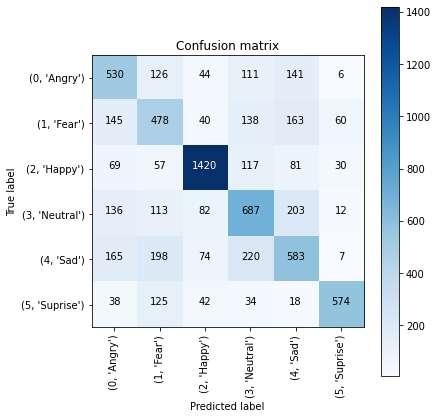

In [21]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

# **Saving and Load Trained Model**

Model progress can be saved during and after training. This means a model can resume where it left off and avoid long training times. Saving also means you can share your model and others can recreate your work. When publishing research models and techniques, most machine learning practitioners share.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
model_save_name = 'classifier.pt'
path = F"/content/drive/MyDrive/Facial Recognition Dataset/{model_save_name}" 
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Facial Recognition Dataset/classifier.pt/assets


In [36]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Facial Recognition Dataset/classifier.pt')

# Check its architecture
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6006      
Total params: 15,233,694
Trainable params: 15,233,694
Non-trainable params: 0
_________________________________________________________________


**Let's try our model and make predictions**

In [37]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [38]:
new_predictions = saved_model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

In [39]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [40]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Angry,Angry
1,Angry/Angry-10.jpg,Neutral,Angry
2,Angry/Angry-100.jpg,Sad,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Angry,Angry


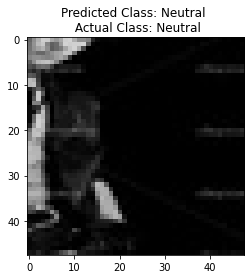

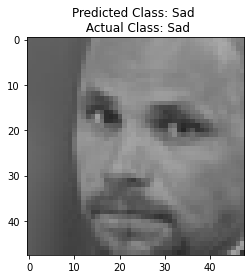

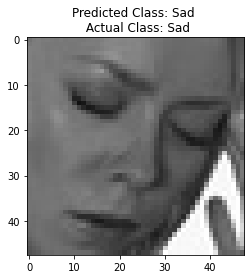

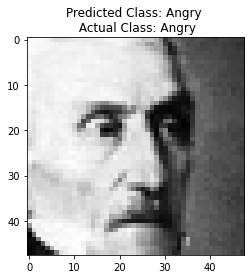

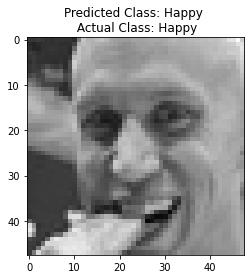

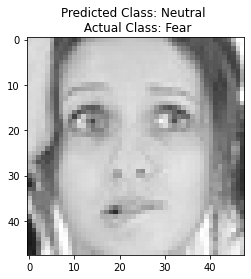

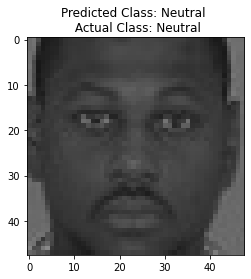

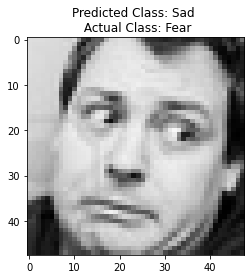

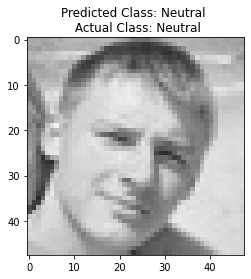

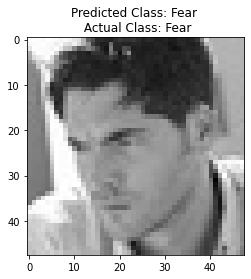

In [43]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass